<a href="https://colab.research.google.com/github/indrajitt/gMLPs-Image-Classification/blob/main/gMLPs_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using gMLPs for Image Classification

This notebook explores the using simple's MLPs with gating as an alternative to vision transformers for image classification. The notebook is based on this paper:

*Hanxiao Liu, Zihang Dai, David R. So, Quoc V. Le (Jun 2021). [Pay Attention to MLPs](https://arxiv.org/abs/2105.08050v2). arXiv:2105.08050 [cs.LG]*

## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import shutil

from torch import nn, optim
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm

# SEED
torch.manual_seed(0)

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla K80


## Understanding the model

The transformer architecture combines two important concepts:  


1. A recurrent-free architecture
which computes the representations for each individual token in parallel  
multi-head selfattention.
2.   Blocks which aggregate spatial information across tokens.  

This model is basically a MLP-based alternative to Transformers without self-attention. It consists of spatial and channel projections with static parameterization.  
***
 To investigate the necessity of the Transformer's self-attention mechanism, the team designed gMLP using only basic MLP layers combined with gating, then compared its performance on vision and language tasks to previous Transformer implementations.On the ImageNet image classification task, gMLP achieves an accuracy of 81.6, comparable to Vision Transformers (ViT) at 81.8, while using fewer parameters and FLOPs.

***
We will now explore the model propsed by the researchers:


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Spatial Gating Unit
The main innovation in gMLP is a Spatial Gating Unit (SGU) which captures the interactions across sequence elements; this performs the same role as attention in a Transformer, but without requiring encodings for element positions. Instead, the SGU performs element-wise multiplication of its input with a linear projection of that same input. The researchers found that for training stability, it was necessary to initialize the weights of the gate to 1, which in effect makes the gate a simple pass-through; in the course of training, the weights are updated to learn the spatial interactions between sequence elements. The image below shows the structure of the spatial gating unit : 

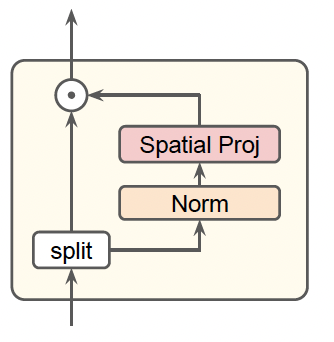

In [4]:
class SpatialGatingUnit(nn.Module):
    def __init__(self, d_ffn, seq_len):
        super().__init__()
        self.norm = nn.LayerNorm(d_ffn)
        self.spatial_proj = nn.Conv1d(seq_len, seq_len, kernel_size=1)
        nn.init.constant_(self.spatial_proj.bias, 1.0)

    def forward(self, x):
        u, v = x.chunk(2, dim=-1)
        v = self.norm(v)
        v = self.spatial_proj(v)
        out = u * v
        return out

### GMLP Block

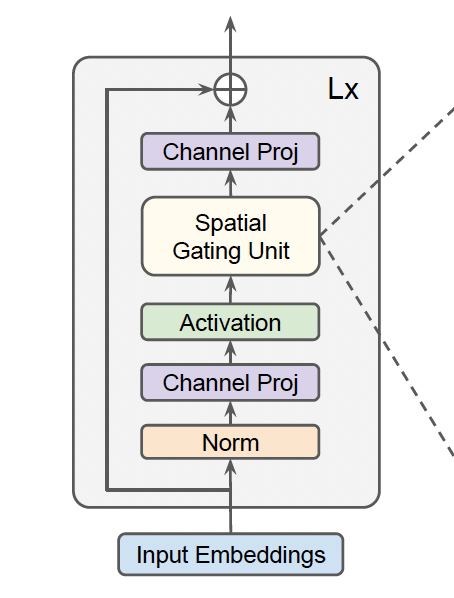


In [5]:
class gMLPBlock(nn.Module):
    def __init__(self, d_model, d_ffn, seq_len):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.channel_proj1 = nn.Linear(d_model, d_ffn * 2)
        self.gelu_activation = nn.GELU()
        self.channel_proj2 = nn.Linear(d_ffn, d_model)
        self.sgu = SpatialGatingUnit(d_ffn, seq_len)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.channel_proj1(x)
        x = self.gelu_activation(x)
        x = self.sgu(x)
        x = self.channel_proj2(x)
        out = x + residual
        return out

In [6]:

class gMLP(nn.Module):
    def __init__(self, d_model=256, d_ffn=512, seq_len=256, num_layers=6):
        super().__init__()
        self.model = nn.Sequential(
            *[gMLPBlock(d_model, d_ffn, seq_len) for _ in range(num_layers)]
        )

    def forward(self, x):
        return self.model(x)

In [7]:
def check_size(image_size, patch_size):
    sqrt_num_patches, remainder = divmod(image_size, patch_size)
    assert remainder == 0, "`image_size` must be divisibe by `patch_size`"
    num_patches = sqrt_num_patches ** 2
    return num_patches


In [8]:
class gMLPForImageClassification(gMLP):
    def __init__(
        self,
        image_size=256,
        patch_size=16,
        in_channels=3,
        num_classes=1000,
        d_model=256,
        d_ffn=512,
        seq_len=256,
        num_layers=6,
    ):
        num_patches = check_size(image_size, patch_size)
        super().__init__(d_model, d_ffn, seq_len, num_layers)
        self.patcher = nn.Conv2d(
            in_channels, d_model, kernel_size=patch_size, stride=patch_size
        )
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        patches = self.patcher(x)
        batch_size, num_channels, _, _ = patches.shape
        patches = patches.permute(0, 2, 3, 1)
        patches = patches.view(batch_size, -1, num_channels)
        embedding = self.model(patches)
        embedding = embedding.mean(dim=1)
        out = self.classifier(embedding)
        return out

## Preparation of dataset for training and evaluation

We chose the CIFAR-10 dataset for the purpose of this Image Classification task. The CIFAR-10 dataset is a standard **balanced dataset** used for several image classification tasks like ImageNet which is used in the paper. The limitations of this dataset is that it consists of a **lesser number of images that are of lower resolution than the images that were used in this paper**. However it is an appropraite dataset for image classification taking into consideration the amount of compute resources that are available to us.

In [9]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
    Output:
        DataLoader Object
    '''
    mean = [0.5, 0.5, 0.5]
    std =  [0.5, 0.5, 0.5]
    if split == 'train':
      train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
      cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
      dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    elif split == 'test':
      test_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
      cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
      dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [10]:
train_dataloader = CIFAR10DataLoader('train')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

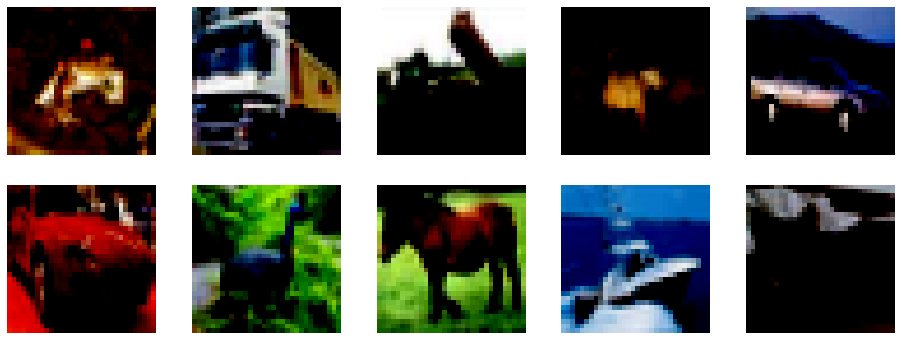

In [11]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_dataloader.dataset.__getitem__(i)
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## Model training and evaluation

In [12]:
# Initializations of all the constants used in the training and testing process
lr = 0.003
batch_size = 128
num_workers = 2
patch_size = 4
classes = 10
channels = 3
epochs = 1

In [13]:
def train(model, dataloader, criterion, optimizer):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to("cuda")
        target = target.to("cuda")
        output = model(data)
        
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

def evaluation(model, dataloader, criterion):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
      
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

In [14]:
model = gMLPForImageClassification(image_size = 32,
      patch_size = patch_size,
      in_channels = channels,
      num_classes = classes,
      d_model=128,
      d_ffn=256,
      seq_len=64,
      num_layers=6)
model = model.cuda()

summary(model, (3, 32, 32), 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 128, 8, 8]           6,272
         LayerNorm-2             [128, 64, 128]             256
            Linear-3             [128, 64, 512]          66,048
              GELU-4             [128, 64, 512]               0
         LayerNorm-5             [128, 64, 256]             512
            Conv1d-6             [128, 64, 256]           4,160
 SpatialGatingUnit-7             [128, 64, 256]               0
            Linear-8             [128, 64, 128]          32,896
         gMLPBlock-9             [128, 64, 128]               0
        LayerNorm-10             [128, 64, 128]             256
           Linear-11             [128, 64, 512]          66,048
             GELU-12             [128, 64, 512]               0
        LayerNorm-13             [128, 64, 256]             512
           Conv1d-14             [128, 

In [15]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 391/391 [00:27<00:00, 14.34it/s]


Epoch : 1 - acc: 0.3710 - loss : 1.7290



100%|██████████| 79/79 [00:04<00:00, 17.73it/s]

test acc: 0.4768 - test loss : 1.4233



In [16]:
# train_accs = [acc.cpu().item() for acc in train_accs]
# test_accs = [acc.cpu().item() for acc in test_accs]

# plt.style.use('seaborn')
# plt.plot(range(1, 101), train_accs, label='Train Accuracy')
# plt.plot(range(1, 101), test_accs, label='Test Accuracy')

# plt.xlabel("Epochs") 
# plt.ylabel("Accuracy")

# plt.title("Train vs Test Accuracy")
# plt.legend(loc='lower right')


## Comparison with ViT
ViT is currently accepted to be the state of the art model for image classification. In this section we compare the performance of gMLP to the ViT model on the same dataset.

[This](https://github.com/ra1ph2/Vision-Transformer) repo was used as a reference for implementation of ViT from scratch.

![Screenshot 2022-04-28 at 10.42.58 AM.png](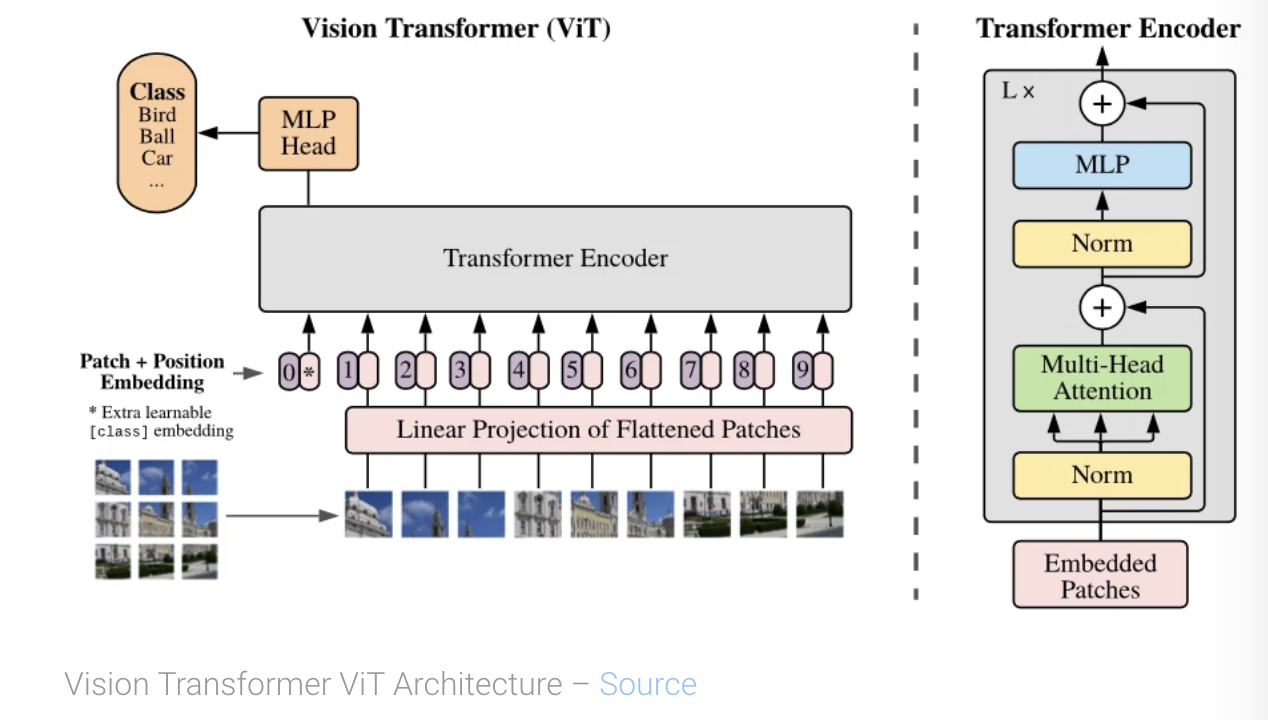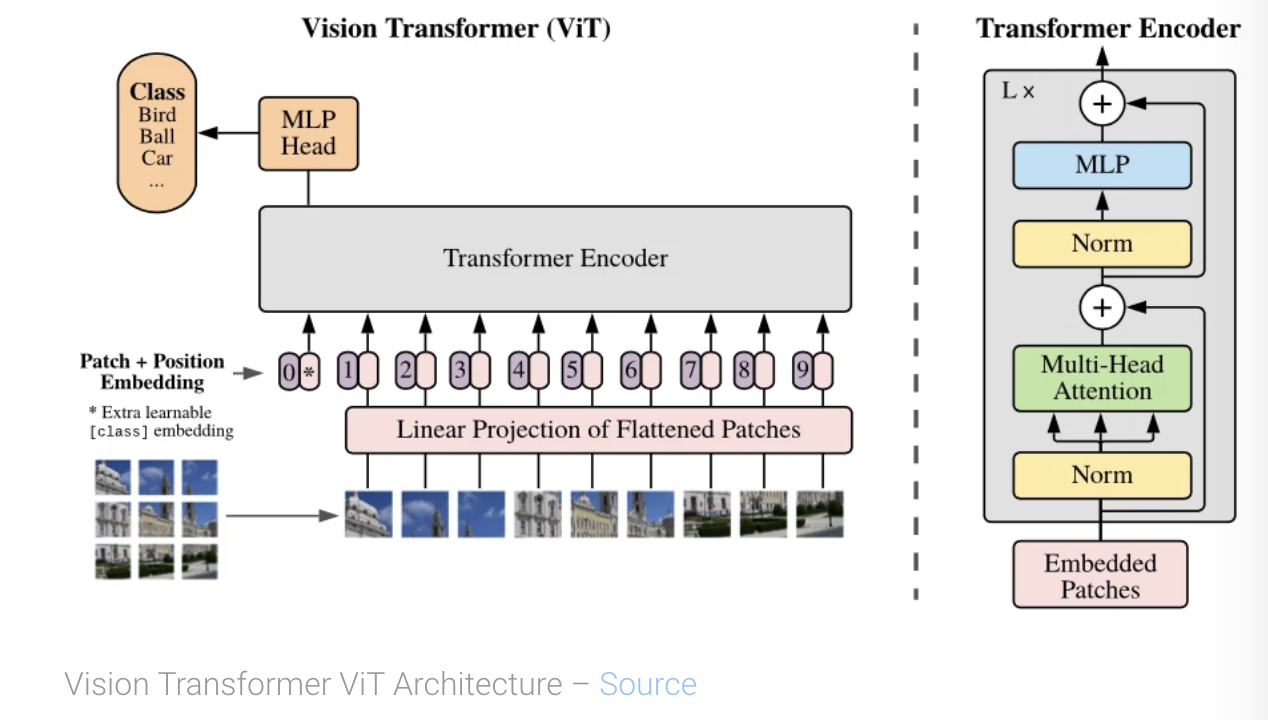)


In [17]:
class Attention(nn.Module):
  """
    Attetion module used to perform self attention in the ViT model.
    
    Args:
      embed_dim: Size of the input embedding.
      heads: Number of parallel attention heads. (default = 8)
      activation: Optional activationto be applied to the inputs while 
                  transforming to key, query and value matrices. (default = None).
                  Accepted values["relu",]
      dropout: Dropout value for the attention layer on the attention scores.
                (default = None)

  """

  def __init__(self, embed_dim, heads=8, activation=None, dropout=None):
    super(Attention, self).__init__()
    self.heads = heads
    self.embed_dim = embed_dim
    
    self.queries = nn.Linear(embed_dim, embed_dim, bias=False)
    self.keys = nn.Linear(embed_dim, embed_dim, bias=False)
    self.values = nn.Linear(embed_dim, embed_dim, bias=False)

    if activation == "relu":
      self.activation = nn.ReLU()
    else:
      self.activation = nn.Identity()
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, input):
    # input.size = (batch_size, seq_len, embed_dim)
    batch_size, seq_len, embed_dim = input.size()
    assert embed_dim == self.embed_dim, "Received input does not have expected\
 embedding dimension"

    queries = self.activation(self.queries(input))  
    keys = self.activation(self.keys(input))  
    values =self.activation(self.values(input))  

    # output : (batch_size * heads, seq_len, reduced_dim)
    queries = self._reshape_heads(queries)  
    keys = self._reshape_heads(keys)  
    values =self._reshape_heads(values) 

    # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
    attention_scores = self.softmax(torch.matmul(queries, keys.transpose(1, 2))) 

    # out: (batch_size * heads, seq_len, reduced_dim)
    out = torch.matmul(self.dropout(attention_scores), values)
    
    # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
    out = self._reshape_heads_back(out)

    return out, attention_scores

  def _reshape_heads(self, inp):
    # inp: (batch_size, seq_len, embed_dim)
    batch_size, seq_len, embed_dim = inp.size()

    reduced_dim = self.embed_dim // self.heads
    assert reduced_dim * self.heads == self.embed_dim
    out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
    out = out.permute(0, 2, 1, 3)
    out = out.reshape(-1, seq_len, reduced_dim)

    # out: (batch_size * heads, seq_len, reduced_dim)
    return out

  def _reshape_heads_back(self, inp):
    # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
    batch_size_mul_heads, seq_len, reduced_dim = inp.size()
    batch_size = batch_size_mul_heads // self.heads

    out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
    out = out.permute(0, 2, 1, 3)
    out = out.reshape(batch_size, seq_len, self.embed_dim)

    # out: (batch_size, seq_len, embed_dim)
    return out


In [18]:
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [19]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [20]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [21]:
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [22]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [23]:
# Vision Transformer Architecture
epochs = 50
model = VisionTransformer(
    patch_size=patch_size,
    max_len=100,
    embed_dim=512,
    classes=classes,
    layers=12,
    channels=channels,
    heads=8).to(device)

In [24]:
def train(model, dataloader, criterion, optimizer):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to("cuda")
        target = target.to("cuda")
        output, _ = model(data)
        
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

def evaluation(model, dataloader, criterion):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)
            output, _ = model(data)
      
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

In [ ]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
# for epoch in range(epochs):

#     running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer)
#     print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
#     train_accs.append(running_accuracy)

#     test_loss, test_accuracy = evaluation(model, test_dataloader, criterion)
#     print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
#     test_accs.append(test_accuracy)

#     if (epoch+1)%5 == 0:
#       torch.save({
#             'epoch': epoch,
#             'model': model,
#             'optimizer': optimizer,
#             'scheduler': scheduler,
#             'train_acc': train_accs,
#             'test_acc': test_accs
#         }, './drive/MyDrive/VisionTransformer/' + model.name + '_CIFAR10_checkpoint.pt') 
      
# To resume from saved epoch, uncomment below and comment above loop.
checkpoint = torch.load('./drive/MyDrive/VisionTransformer/' + model.name + '_CIFAR10_checkpoint.pt')
model = checkpoint['model']
last_epoch = checkpoint['epoch']
optimizer = checkpoint['optimizer']
schdeuler = checkpoint['scheduler']
train_accs = checkpoint['train_acc']
test_accs = checkpoint['test_acc']
print(last_epochtjo)
for epoch in range(last_epoch+1, epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
      torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './drive/MyDrive/VisionTransformer/' + model.name + '_CIFAR10_checkpoint.pt') 



Files already downloaded and verified
Files already downloaded and verified
9


100%|██████████| 391/391 [04:15<00:00,  1.53it/s]


Epoch : 11 - acc: 0.6705 - loss : 0.9185



100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


test acc: 0.5860 - test loss : 1.1703



100%|██████████| 391/391 [04:15<00:00,  1.53it/s]


Epoch : 12 - acc: 0.6777 - loss : 0.8937



100%|██████████| 79/79 [00:17<00:00,  4.63it/s]


test acc: 0.5923 - test loss : 1.1449



100%|██████████| 391/391 [04:13<00:00,  1.55it/s]


Epoch : 13 - acc: 0.6862 - loss : 0.8742



100%|██████████| 79/79 [00:17<00:00,  4.59it/s]


test acc: 0.5942 - test loss : 1.1569



100%|██████████| 391/391 [04:13<00:00,  1.54it/s]


Epoch : 14 - acc: 0.6942 - loss : 0.8541



100%|██████████| 79/79 [00:17<00:00,  4.60it/s]


test acc: 0.5937 - test loss : 1.1538



100%|██████████| 391/391 [04:13<00:00,  1.54it/s]


Epoch : 15 - acc: 0.7071 - loss : 0.8205



100%|██████████| 79/79 [00:17<00:00,  4.60it/s]


test acc: 0.5860 - test loss : 1.1753



100%|██████████| 391/391 [04:13<00:00,  1.54it/s]


Epoch : 16 - acc: 0.7074 - loss : 0.8117



100%|██████████| 79/79 [00:17<00:00,  4.60it/s]


test acc: 0.5898 - test loss : 1.1765



100%|██████████| 391/391 [04:13<00:00,  1.54it/s]


Epoch : 17 - acc: 0.7226 - loss : 0.7738



100%|██████████| 79/79 [00:17<00:00,  4.60it/s]


test acc: 0.6021 - test loss : 1.1558



100%|██████████| 391/391 [04:16<00:00,  1.53it/s]


Epoch : 18 - acc: 0.7251 - loss : 0.7622



100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


test acc: 0.6065 - test loss : 1.1642



100%|██████████| 391/391 [04:17<00:00,  1.52it/s]


Epoch : 19 - acc: 0.7332 - loss : 0.7420



100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


test acc: 0.5909 - test loss : 1.2041



100%|██████████| 391/391 [04:16<00:00,  1.52it/s]


Epoch : 20 - acc: 0.7368 - loss : 0.7311



100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


test acc: 0.6016 - test loss : 1.1769



100%|██████████| 391/391 [04:16<00:00,  1.52it/s]


Epoch : 21 - acc: 0.7461 - loss : 0.7033



100%|██████████| 79/79 [00:17<00:00,  4.56it/s]


test acc: 0.5998 - test loss : 1.1939



100%|██████████| 391/391 [04:16<00:00,  1.52it/s]


Epoch : 22 - acc: 0.7552 - loss : 0.6802



100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


test acc: 0.5934 - test loss : 1.2216



 31%|███▏      | 123/391 [01:20<02:55,  1.52it/s]

In [ ]:
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

## Results and conclusions
We observe that the training accuracy is close to 99% while the the test accuracy remains around 65%. This indicates that the model is over fitting. In our next submission, we will address this issue. However, we note that the gMLP performs reasonably well on a dataset of smaller size and lesser resolution.

## Post Midsem Work
Post midsem submission, we will try and make the follwoing changes/explorations:
1. Compare performance with ViT on same dataset using same compute power.
2. Try and add self attention to gMLP to improve performance.
3. Explore other modifications to improve the performance.

